# Fire Hazard Incidents Analytics Pipeline

## Importing Required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

import numpy as np
import matplotlib.pyplot as plt

## Creating Spark Session

In [2]:
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

## Loading basic module data

In [3]:
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")

In [4]:
# Dropping null values in loss tables and finding total loss
basic_module_df = basic_module_df.na.drop(subset=("PROP_LOSS","CONT_LOSS"))

In [5]:
# Formatting datetime columns
basic_time_module_df = basic_module_df.withColumn("ALARM_TIME", F.to_timestamp("ALARM","MMddyyyyHHmm")).withColumn("CONT_TIME", F.to_timestamp("INC_CONT","MMddyyyyHHmm")).withColumn("ARV_TIME", F.to_timestamp("ARRIVAL","MMddyyyyHHmm"))

In [6]:
# Finding total fire time
total_fire_time_df = basic_time_module_df.withColumn("TOTAL_FIRE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ALARM_TIME.cast("long"))

In [7]:
# Removing non-sensical data
time_loss_predict_df = total_fire_time_df.na.drop(subset=(["TOTAL_FIRE_TIME","CONT_LOSS"])).filter(total_fire_time_df.TOTAL_FIRE_TIME>0).filter(total_fire_time_df.CONT_LOSS>0).select(["TOTAL_FIRE_TIME","CONT_LOSS"]).groupBy("TOTAL_FIRE_TIME").agg(F.avg("CONT_LOSS").alias("AVG_LOSS"))


In [8]:
# Checking linear correlation between input and output
test2 = time_loss_predict_df.toPandas().astype('float')
test2["TOTAL_FIRE_TIME"].corr(test2["AVG_LOSS"])

0.7376856891210598

In [9]:
# Adding higher order columns for better predictions
time_loss_predict_df = time_loss_predict_df.select("*", F.pow("TOTAL_FIRE_TIME", 2).alias("time_square")).select("*", F.pow("TOTAL_FIRE_TIME", 3).alias("time_cube")).select("*", F.pow("TOTAL_FIRE_TIME", 4).alias("time_four"))

In [10]:
# Creating input vector for model
assembler = VectorAssembler(inputCols=["TOTAL_FIRE_TIME","time_square","time_cube","time_four"], 
                            outputCol="features")
myGraph_vector = assembler.transform(time_loss_predict_df).select(["features","AVG_LOSS"])

In [21]:
splits = myGraph_vector.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [22]:
lr = LinearRegression(featuresCol = 'features', labelCol='AVG_LOSS', maxIter=1000, regParam=0.3)

In [23]:
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-7.964791505678384,1.0219886208177624e-05,-2.022784364233064e-12,1.1027416401387721e-19]
Intercept: 380493.6335430327


In [24]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 2210734.310245
r2: 0.604632


In [25]:
train_df.describe().show()

+-------+-----------------+
|summary|         AVG_LOSS|
+-------+-----------------+
|  count|              541|
|   mean|465016.5789125834|
| stddev|3519149.880837068|
|    min|              1.0|
|    max|           5.04E7|
+-------+-----------------+



In [26]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.filter(lr_predictions.prediction>0).select("prediction","features","AVG_LOSS").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="AVG_LOSS",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+--------------------+------------------+
|        prediction|            features|          AVG_LOSS|
+------------------+--------------------+------------------+
| 375241.3223501957|[660.0,435600.0,2...| 3133.033579583613|
|  374764.280892984|[720.0,518400.0,3...| 9646.496527777777|
| 371903.5766441975|[1080.0,1166400.0...| 11108.69869402985|
|370950.59687721566|[1200.0,1440000.0...|10170.220077220078|
| 369997.9112332618|[1320.0,1742400.0...|11325.771871539313|
+------------------+--------------------+------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.775414


In [27]:
train_pd = time_loss_predict_df.select(["TOTAL_FIRE_TIME","AVG_LOSS"]).toPandas()

In [28]:
tp1 = np.linspace(0,max(train_pd["TOTAL_FIRE_TIME"]),1000).reshape((1000,1))
tp2 = tp1**2
tp3 = tp1**3
tp4 = tp1**4
test_predict = np.hstack((tp1,tp2,tp3,tp4))

In [29]:
results = []

for i in range(1000):
    results.append(lr_model.predict(Vectors.dense(test_predict[i,:])))

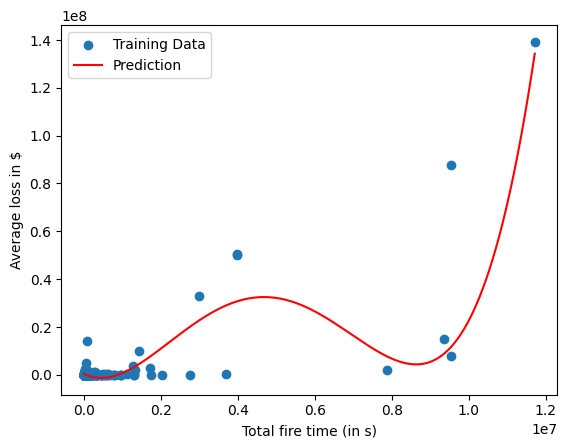

In [30]:
plt.scatter(train_pd["TOTAL_FIRE_TIME"],train_pd["AVG_LOSS"], label = "Training Data")
plt.plot(tp1, results, color = "r", label = "Prediction")
plt.legend()
plt.xlabel("Total fire time (in s)")
plt.ylabel("Average loss in $")
# plt.xlim(0,100000)
# plt.ylim(0,1000000)
plt.savefig("lr_model1.png")
plt.show()